    softmax回归适⽤于分类问题。它使⽤softmax运算输出类别的概率分布。
    softmax回归是⼀个单层神经⽹络，输出个数等于分类问题中的类别个数。
    交叉熵适合衡量两个概率分布的差异

本节我们将使⽤torchvision包，它是服务于PyTorch深度学习框架的，主要⽤来构建计算机视觉模型。
torchvision主要由以下⼏部分构成：
1. torchvision.datasets : ⼀些加载数据的函数及常⽤的数据集接⼝；
2. torchvision.models : 包含常⽤的模型结构（含预训练模型），例如AlexNet、VGG、ResNet等；
3. torchvision.transforms : 常⽤的图⽚变换，例如裁剪、旋转等；
4. torchvision.utils : 其他的⼀些有⽤的⽅法。

# 获取数据集

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import sys
from IPython import display
import numpy as np

In [2]:
mnist_train=torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST',train=True,download=True,transform=transforms.ToTensor())
mnist_test=torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST',train=False,download=True,transform=transforms.ToTensor())

In [3]:
print(type(mnist_train))
print(len(mnist_train),len(mnist_test))

<class 'torchvision.datasets.mnist.FashionMNIST'>
60000 10000


In [4]:
feature,label=mnist_train[0]
print(feature.shape,label)

torch.Size([1, 28, 28]) 9


In [5]:
def get_fashion_mnist_labels(labels):
    text_labels=['t-shirt', 'trouser', 'pullover', 'dress','coat','sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [6]:
def use_svg_display():
    #用矢量图显示
    display.set_matplotlib_formats('svg')

def show_fashion_mnist(images,labels):
        use_svg_display()
        _,figs=plt.subplots(1,len(images),figsize=(12,12))
        for f,img,lbl in zip(figs,images,labels):
            f.imshow(img.view((28,28)).numpy())
            f.set_title(lbl)
            f.axes.get_xaxis().set_visible(False)
            f.axes.get_yaxis().set_visible(False)
        plt.show()

<ipython-input-6-547943cf72b3>:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


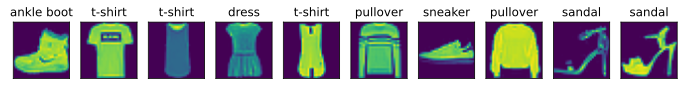

In [7]:
X,y=[],[]
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
show_fashion_mnist(X,get_fashion_mnist_labels(y))

# 读取小批量

In [8]:
batch_size=256
if sys.platform.startswith('win'):
    num_workers=0
else:
    num_workers=4
train_iter=torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=num_workers)
test_iter=torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=False,num_workers=num_workers)

In [9]:
start=time.time()
for X,y in train_iter:
    continue
print('%.2fsec'%(time.time()-start))

5.94sec


# 初始化模型参数

In [10]:
num_inputs=784
num_outputs=10

W=torch.tensor(np.random.normal(0,0.01,(num_inputs,num_outputs)),dtype=torch.float)
b=torch.zeros(num_outputs,dtype=torch.float)

In [11]:
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

# 实现SOFTMAX运算

In [12]:
def softmax(X):
    X_exp=X.exp()
    partition=X_exp.sum(dim=1,keepdim=True)
    return X_exp / partition

In [13]:
X=torch.rand((2,5))
X_prob=softmax(X)
print(X_prob,X_prob.sum(dim=1))

tensor([[0.2233, 0.1543, 0.2462, 0.2018, 0.1744],
        [0.2106, 0.1586, 0.1721, 0.2390, 0.2197]]) tensor([1., 1.])


# 定义模型

In [14]:
def net(X):
    return softmax(torch.mm(X.view((-1,num_inputs)),W)+b)

# 定义损失函数

In [15]:
y_hat=torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5]])
y=torch.LongTensor([0,2])
y_hat.gather(1,y.view(-1,1))

tensor([[0.1000],
        [0.5000]])

In [16]:
def cross_entropy(y_hat,y):
    return -torch.log(y_hat.gather(1,y.view(-1,1)))

# 定义优化算法

In [17]:
def sgd(params,lr,batch_size):
    for param in params:
        param.data-=lr*param.grad/batch_size

# 计算分类准确率

In [18]:
def accuracy(y_hat,y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

In [46]:
print(accuracy(y_hat,y))

0.5


In [19]:
def evaluate_accuracy(data_iter,net):
    acc_sum,n=0.0,0
    for X,y in data_iter:
        acc_sum+=(net(X).argmax(dim=1)==y).float().sum().item()
        n+=y.shape[0]
    return acc_sum/n

In [50]:
print(evaluate_accuracy(test_iter,net))

0.0798


# 训练模型

In [20]:
num_epochs,lr=5,0.1

def train_ch3(net,train_iter,test_iter,loss,num_epochs,batch_size,params=None,lr=None,optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            y_hat=net(X)
            l=loss(y_hat,y).sum()
            
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
                    
            l.backward()
            if optimizer is None:
                sgd(params,lr,batch_size)
            else:
                optimizer.step()
                
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        
        test_acc=evaluate_accuracy(test_iter,net)
        print('epoch %d,loss %.4f,train acc %.3f,test acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,test_acc))

In [21]:
train_ch3(net,train_iter,test_iter,cross_entropy,num_epochs,batch_size,[W,b],lr)

epoch 1,loss 0.7833,train acc 0.750,test acc 0.795
epoch 2,loss 0.5699,train acc 0.812,test acc 0.808
epoch 3,loss 0.5246,train acc 0.826,test acc 0.819
epoch 4,loss 0.5018,train acc 0.833,test acc 0.824
epoch 5,loss 0.4859,train acc 0.836,test acc 0.826


# 预测

<ipython-input-6-547943cf72b3>:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


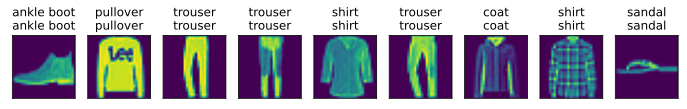

In [22]:
X,y=iter(test_iter).next()
true_labels=get_fashion_mnist_labels(y.numpy())
pred_labels=get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles=[true +'\n'+pred for true,pred in zip(true_labels,pred_labels)]
show_fashion_mnist(X[0:9],titles[0:9])

# 保存模型

In [23]:
torch.save(net,'network.pth')

# 打印参数

In [24]:
torch.set_printoptions(profile="full")
print(W)
print(b)

tensor([[-6.8534e-03, -9.0652e-03,  1.5262e-02,  1.5785e-03,  6.3155e-03,
          9.0746e-03, -5.9111e-03,  1.5079e-02,  2.5548e-03, -1.1821e-02],
        [-9.9128e-03, -1.0863e-02, -6.5969e-03, -7.4628e-03,  3.6914e-03,
          2.9013e-03,  3.9229e-03,  1.3402e-03, -3.7717e-03,  1.4517e-02],
        [-3.9486e-03,  4.0623e-03, -1.7300e-02, -1.0831e-02, -1.7259e-02,
          7.8210e-03,  2.5807e-03, -1.3005e-03, -1.1664e-02, -5.0036e-03],
        [ 1.3282e-02, -9.2048e-05, -5.8875e-03,  5.2942e-03,  1.6760e-02,
         -1.0644e-02, -1.5199e-03,  3.2192e-03, -2.2793e-03, -7.0475e-03],
        [-2.9583e-02,  9.1798e-03,  8.1990e-04, -1.9118e-02,  1.3663e-02,
          1.3172e-02, -4.6226e-03,  3.5239e-04,  1.7590e-02, -3.2315e-03],
        [-1.8317e-02,  1.4274e-02, -2.8162e-02,  5.5958e-03,  1.0378e-03,
          1.6936e-02,  1.8927e-02, -5.6980e-03,  8.0862e-03,  3.6116e-03],
        [-1.8525e-02,  4.1239e-02, -4.1411e-02,  1.0526e-02,  6.6933e-03,
         -1.2559e-02,  1.6187e-0